#Import Libraries

In [1]:
pip install heartpy wfdb shap

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import scipy.signal
from scipy.fftpack import fft, fftfreq
from scipy.signal import welch
from scipy.stats import skew, kurtosis
import pywt
import heartpy as hp
from scipy.signal import butter, lfilter
import pywt

def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y

def preprocess_signal(signal, fs):
    # Bandpass filtering
    signal = bandpass_filter(signal, 0.5, 5.0, fs)  # Adjust these values as needed

    return signal

def global_features(signal, fs, is_ecg=False):

    signal = preprocess_signal(signal, fs)
    return common_features(signal, fs, is_ecg)

def local_features(signal, fs, is_ecg=False):
    features_list = []

    # Constants defining the number of windows and the number of features
    NUM_WINDOWS = 6
    NUM_FEATURES_PER_WINDOW = 10
    window_size = len(signal) // NUM_WINDOWS

    cutoff_freq = 10.0  # You can adjust this based on your knowledge of the signal
    signal = preprocess_signal(signal, fs)

    for i in range(NUM_WINDOWS):
        start_idx = i * window_size
        end_idx = (i + 1) * window_size
        neighborhood = signal[start_idx:end_idx]

        features = common_features(neighborhood, fs, is_ecg)
        selected_features = [features[key] for key in sorted(features.keys())]#[:NUM_FEATURES_PER_WINDOW]]
        features_list.append(features)

    return features_list

def common_features(signal, fs, is_ecg=False):
    features = {}

    # Ensure signal is a 1D array
    signal = np.squeeze(signal)

    # Check for NaN values and handle them if necessary
    if np.isnan(signal).any():
        signal = signal[~np.isnan(signal)]

    # Verify if the signal has at least one element to avoid errors
    if signal.size == 0:
        # Handle the empty signal case by returning empty features
        return features

    features['mean'] = np.mean(signal)
    features['median'] = np.median(signal)
    features['variance'] = np.var(signal)
    features['std_dev'] = np.std(signal)
    features['skewness'] = skew(signal)
    features['kurtosis'] = kurtosis(signal)

    peaks, _ = scipy.signal.find_peaks(signal)
    valleys, _ = scipy.signal.find_peaks(-signal)
    features['num_peaks'] = len(peaks)
    features['num_valleys'] = len(valleys)

    fft_vals = fft(signal)
    fft_freq = fftfreq(len(signal), 1/fs)
    norm_vals = np.abs(fft_vals)
    norm_vals = norm_vals / sum(norm_vals)
    features['spectral_entropy'] = -sum(norm_vals * np.log2(norm_vals))

    freqs, psd_values = welch(signal, fs=fs)
    features['dom_freq'] = freqs[np.argmax(psd_values)]

    cA, cD = pywt.dwt(signal, 'db1')

    if is_ecg:
      # HeartPy analysis
      wd, m = hp.process(hp.scale_data(signal), fs)  # Error line

      features['mean_nni'] = m['bpm']
      features['sdnn'] = m['sdnn']
      features['sdsd'] = m['sdsd']
      features['pnn20'] = m['pnn20']
      features['pnn50'] = m['pnn50']
      features['rmssd'] = m['rmssd']
      features['sd1'] = m['sd1']
      features['sd2'] = m['sd2']
      features['respiratory_rate'] = m['breathingrate']

    return features

def estimate_respiratory_rate(signal, fs):
    freqs, psd_values = welch(signal, fs=fs)
    respiratory_freq_range = (freqs >= 0.2) & (freqs <= 0.5)

    if np.any(respiratory_freq_range):  # Check if there are any values within the specified range
        dominant_respiratory_freq = freqs[respiratory_freq_range][np.argmax(psd_values[respiratory_freq_range])]
        respiratory_rate = dominant_respiratory_freq * 60
    else:
        respiratory_rate = np.nan  # Return NaN if no values are found within the specified range

    return respiratory_rate

def detect_motion_artifact(signal, threshold=1.0):
    first_derivative = np.abs(np.gradient(signal))
    return np.mean(first_derivative) > threshold

#Global Features

##Multilabel


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.


Cross-Validation Accuracies: [0.42857143 0.46153846 0.69230769 0.38461538 0.53846154]
Average Cross-Validation Accuracy: 0.50
Test Accuracy: 50.00%
Classification Report:
              precision    recall  f1-score   support

         run       0.50      0.29      0.36         7
         sit       1.00      0.75      0.86         4
        walk       0.29      0.67      0.40         3

    accuracy                           0.50        14
   macro avg       0.60      0.57      0.54        14
weighted avg       0.60      0.50      0.51        14



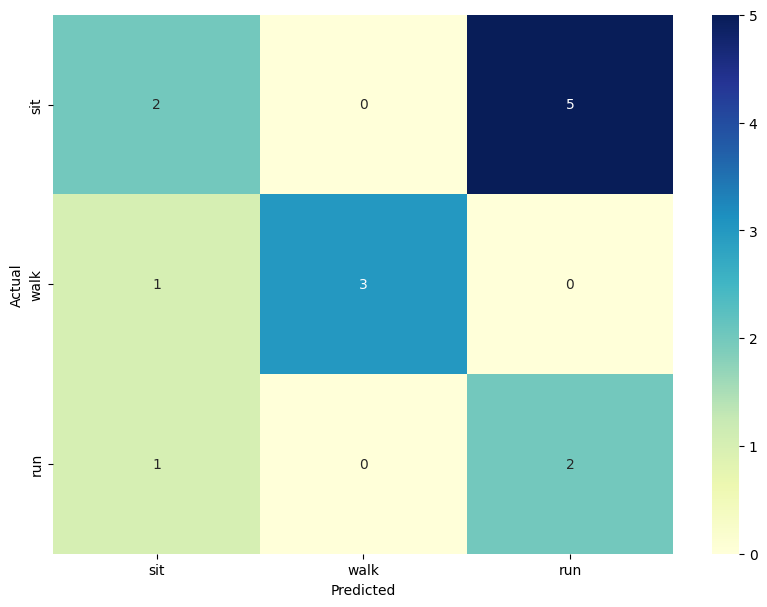

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Average Accuracy: 50.11%
Average Precision: 0.49
Average Recall: 0.50
Average F1-score: 0.49


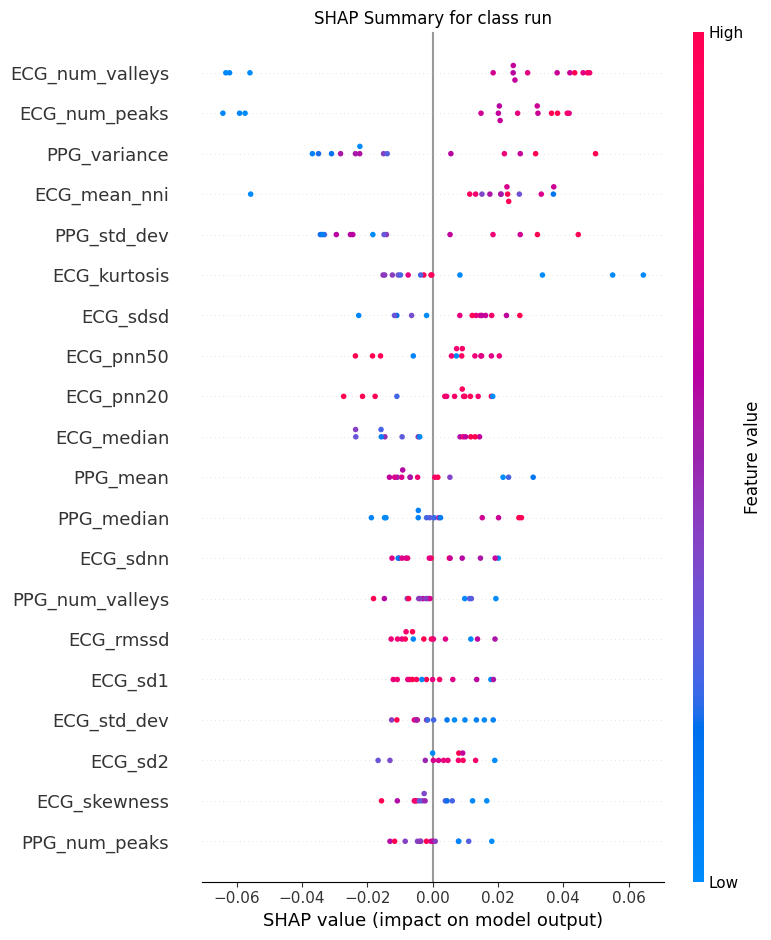

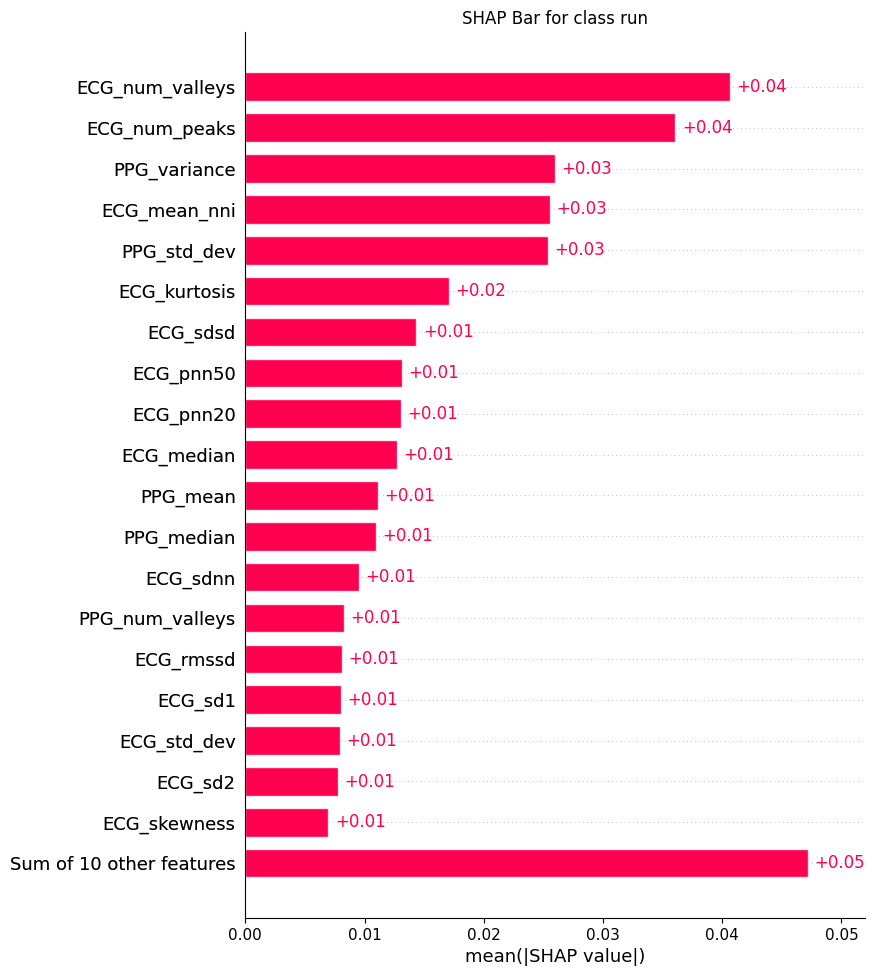

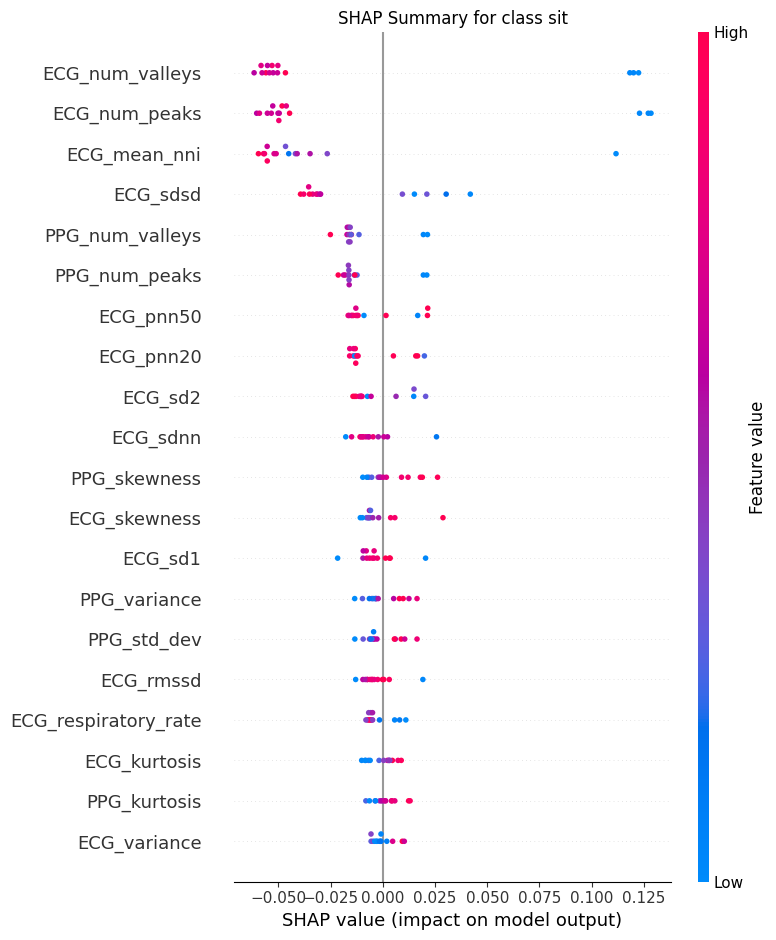

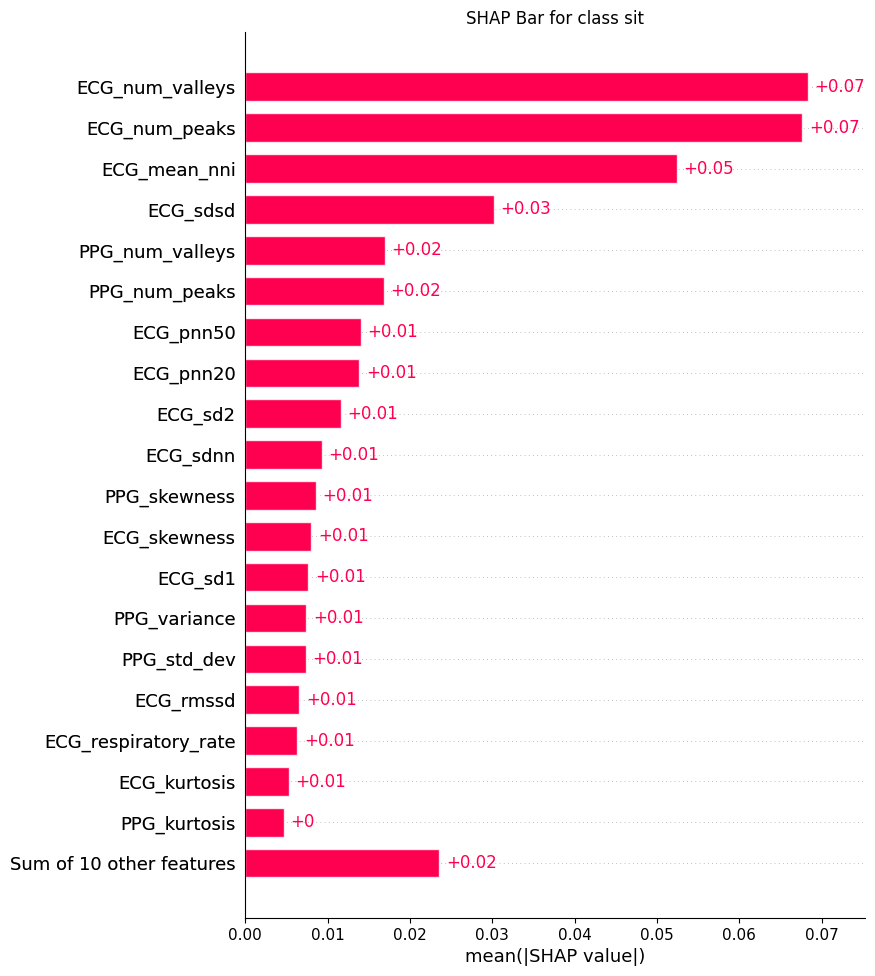

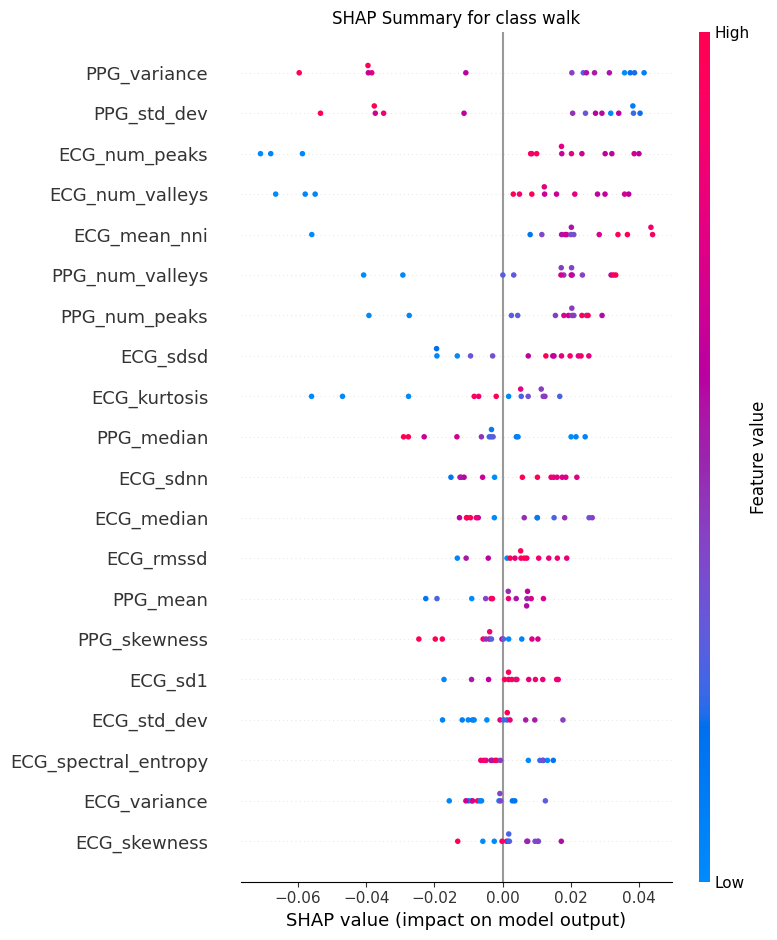

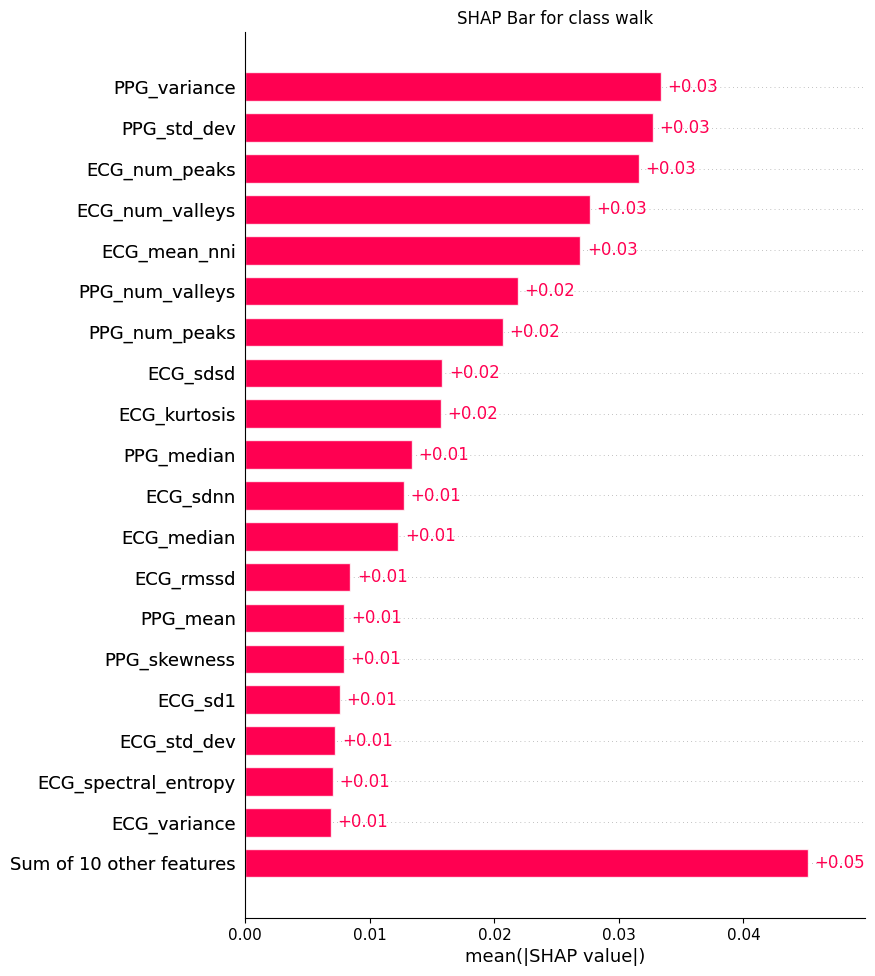

In [5]:
import shap
import wfdb
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

folder_path = '/Users/roupenminassian/physionet.org/files/pulse-transit-time-ppg/1.1.0/Data/' # Update with your path

features = []
labels = []

# Sampling frequency
fs = 500

# Iterate through all files in the directory
for filename in os.listdir(folder_path):
    if filename.endswith(".dat"):  # Assuming the wfdb data format with .dat extension
        # Extract the label from the filename (e.g., "sit" from "s20_sit")
        label = filename.split('_')[1].split('.')[0]
        labels.append(label)

        # Construct the record name without extensions
        record_name = os.path.join(folder_path, filename.split('.')[0])

        # Load the record using wfdb
        record = wfdb.rdrecord(record_name)

        # Extract ECG and PPG signals
        ecg_index = record.sig_name.index('ecg')
        ecg_signal = record.p_signal[:, ecg_index]
        pleth_2_index = record.sig_name.index('pleth_2')
        pleth_2_signal = record.p_signal[:, pleth_2_index]

        # Extract global features
        ecg_features_raw = global_features(ecg_signal, fs, is_ecg=True)
        ppg_features_raw = global_features(pleth_2_signal, fs, is_ecg=False)

        # Prefix the feature names to differentiate
        ecg_features = {"ECG_" + k: v for k, v in ecg_features_raw.items()}
        ppg_features = {"PPG_" + k: v for k, v in ppg_features_raw.items()}

        # Combine features
        all_features = {**ecg_features, **ppg_features}
        features.append(list(all_features.values()))

# Convert features and labels into NumPy arrays
X = np.array(features)
y = np.array(labels)

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Initialize lists to store metrics
all_precision = []
all_recall = []
all_f1 = []
all_accuracy = []

# Cross-validation setup
cv = StratifiedKFold(n_splits=5)  # 5-fold cross-validation
clf = RandomForestClassifier(n_estimators=1000, random_state=42)
cross_val_accuracies = cross_val_score(clf, X_normalized, y, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Average Cross-Validation Accuracy: {np.mean(cross_val_accuracies):.2f}")

# Split the normalized dataset
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Get the class labels
class_labels = clf.classes_

# Get the feature names (Assuming all_features.keys() has them)
feature_names = list(all_features.keys())

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate additional metrics (Recall, F1, Precision)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", xticklabels=['sit', 'walk', 'run'], yticklabels=['sit', 'walk', 'run'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.close()

# Calculate and plot shapley
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Plot SHAP values for each class
for i, label in enumerate(class_labels):
    plt.figure(figsize=(16, 10))
    plt.title(f"SHAP Summary for class {label}")

    # Display SHAP summary plot
    shap.summary_plot(shap_values[i], X_test, feature_names=feature_names, show=False)

    # Create Explanation object for bar plot
    expected_value = explainer.expected_value[i]
    explanation = shap.Explanation(values=shap_values[i],
                                   base_values=expected_value,
                                   data=X_test,
                                   feature_names=feature_names)

    plt.figure(figsize=(16, 10))
    plt.title(f"SHAP Bar for class {label}")

    # Display SHAP bar plot
    shap.plots.bar(explanation, max_display=20, show=False)

# Loop through each fold
for train_index, test_index in cv.split(X_normalized, y):
    X_train, X_test = X_normalized[train_index], X_normalized[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    all_accuracy.append(accuracy)
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)

# Calculate average metrics
avg_accuracy = np.mean(all_accuracy)
avg_precision = np.mean(all_precision)
avg_recall = np.mean(all_recall)
avg_f1 = np.mean(all_f1)

print(f"Average Accuracy: {avg_accuracy * 100:.2f}%")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1-score: {avg_f1:.2f}")

##Binary


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.


Cross-Validation Accuracies: [0.85714286 1.         0.92307692 0.92307692 0.84615385]
Average Cross-Validation Accuracy: 0.91
Test Accuracy: 92.86%
Classification Report:
              precision    recall  f1-score   support

    movement       0.91      1.00      0.95        10
        rest       1.00      0.75      0.86         4

    accuracy                           0.93        14
   macro avg       0.95      0.88      0.90        14
weighted avg       0.94      0.93      0.93        14



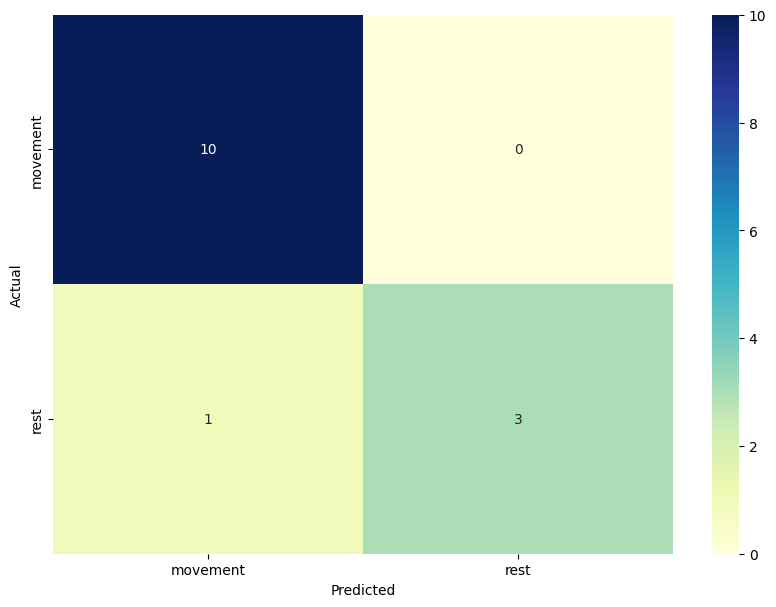

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Average Accuracy: 90.99%
Average Precision: 0.92
Average Recall: 0.91
Average F1-score: 0.91


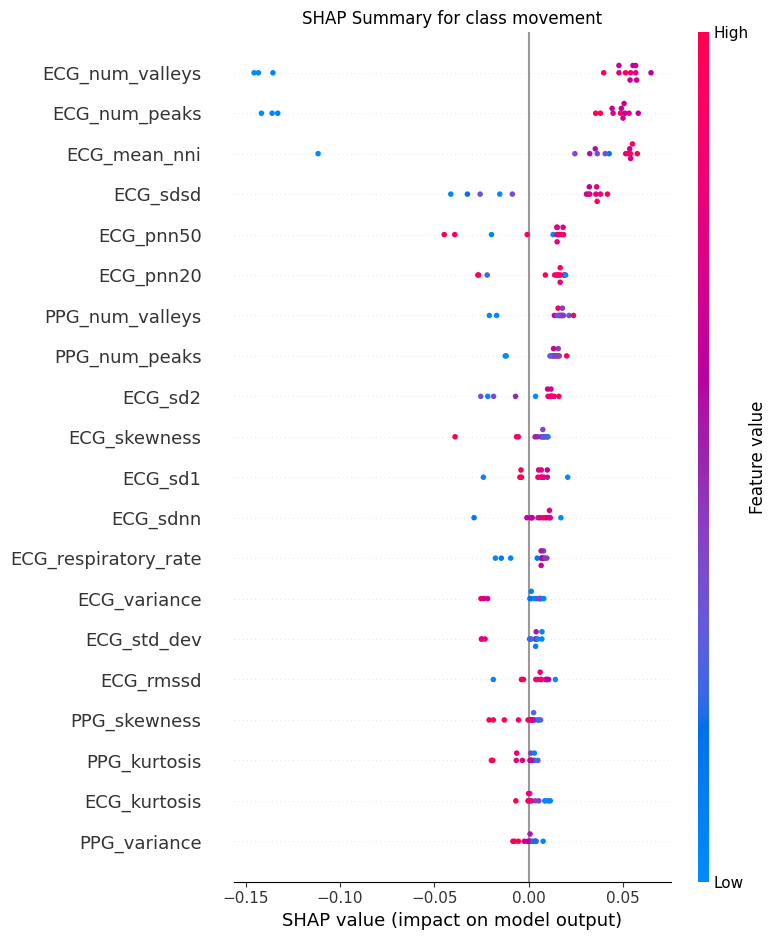

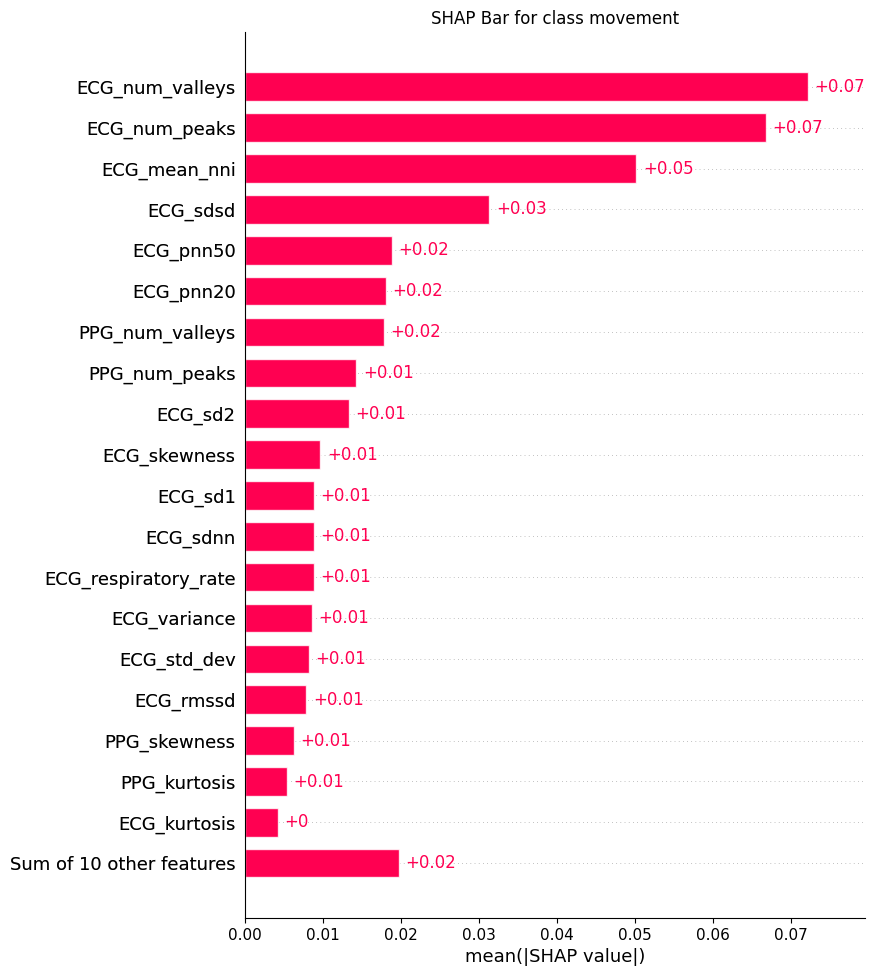

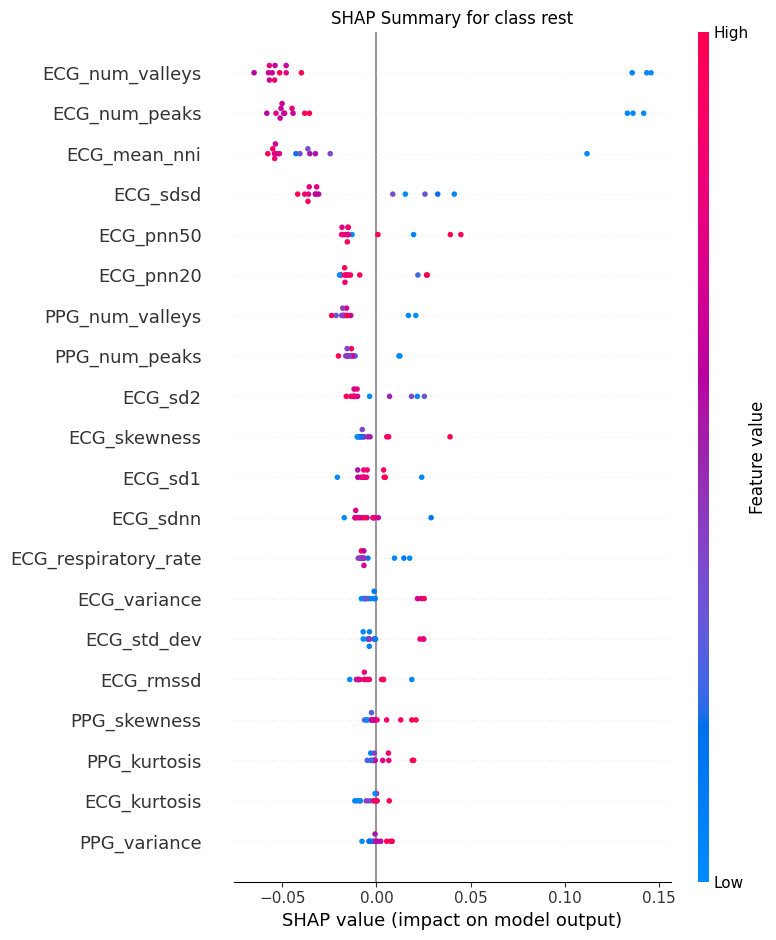

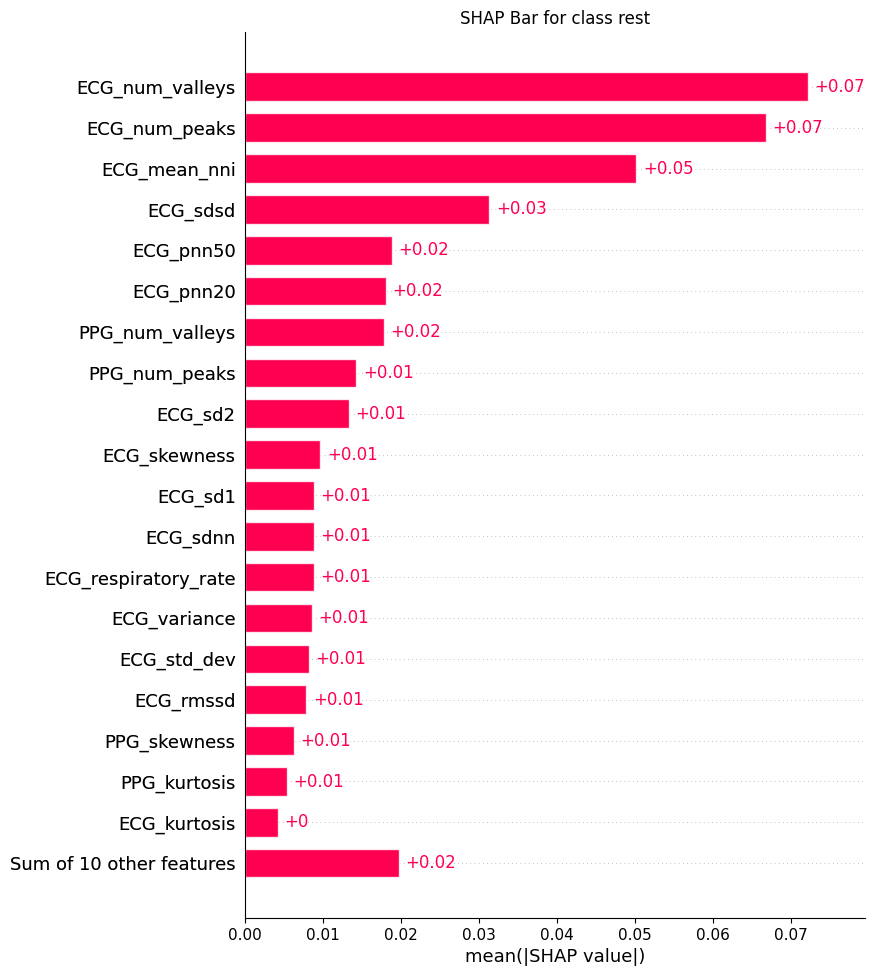

In [8]:
import shap
import wfdb
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

folder_path = '/Users/roupenminassian/physionet.org/files/pulse-transit-time-ppg/1.1.0/Data/'  # Update with your path

features = []
labels = []

# Sampling frequency
fs = 500

# Function to create directory structure
def create_directory_structure(base_folder):
    dir_structure = os.path.join(base_folder, "Subject_Independent_Model", "Global", "Binary")
    if not os.path.exists(dir_structure):
        os.makedirs(dir_structure)
    return dir_structure

# Iterate through all files in the directory
for filename in os.listdir(folder_path):
    if filename.endswith(".dat"):  # Assuming the wfdb data format with .dat extension
        # Extract the label from the filename (e.g., "sit" from "s20_sit")
        label = filename.split('_')[1].split('.')[0]

        # Convert 'run' and 'walk' labels to 'movement'
        if label in ['run', 'walk']:
            label = 'movement'

        if label == 'sit':
            label = 'rest'

        labels.append(label)

        # Construct the record name without extensions
        record_name = os.path.join(folder_path, filename.split('.')[0])

        # Load the record using wfdb
        record = wfdb.rdrecord(record_name)

        # Extract ECG and PPG signals
        ecg_index = record.sig_name.index('ecg')
        ecg_signal = record.p_signal[:, ecg_index]
        pleth_2_index = record.sig_name.index('pleth_2')
        pleth_2_signal = record.p_signal[:, pleth_2_index]

        # Extract global features
        ecg_features_raw = global_features(ecg_signal, fs, is_ecg=True)
        ppg_features_raw = global_features(pleth_2_signal, fs, is_ecg=False)

        # Prefix the feature names to differentiate
        ecg_features = {"ECG_" + k: v for k, v in ecg_features_raw.items()}
        ppg_features = {"PPG_" + k: v for k, v in ppg_features_raw.items()}

        # Combine features
        all_features = {**ecg_features, **ppg_features}
        features.append(list(all_features.values()))

# Convert features and labels into NumPy arrays
X = np.array(features)
y = np.array(labels)

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Initialize lists to store metrics
all_precision = []
all_recall = []
all_f1 = []
all_accuracy = []

# Cross-validation setup
cv = StratifiedKFold(n_splits=5)  # 5-fold cross-validation
clf = RandomForestClassifier(n_estimators=1000, random_state=42)
cross_val_accuracies = cross_val_score(clf, X_normalized, y, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Average Cross-Validation Accuracy: {np.mean(cross_val_accuracies):.2f}")

# Split the normalized dataset
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Get the class labels
class_labels = clf.classes_

# Get the feature names (Assuming all_features.keys() has them)
feature_names = list(all_features.keys())

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate additional metrics (Recall, F1, Precision)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.close()

# Calculate and plot Shapley values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Plot SHAP values for each class
for i, label in enumerate(class_labels):
    plt.figure(figsize=(16, 10))
    plt.title(f"SHAP Summary for class {label}")

    # Display SHAP summary plot
    shap.summary_plot(shap_values[i], X_test, feature_names=feature_names, show=False)

    # Create Explanation object for bar plot
    expected_value = explainer.expected_value[i]
    explanation = shap.Explanation(values=shap_values[i],
                                   base_values=expected_value,
                                   data=X_test,
                                   feature_names=feature_names)

    plt.figure(figsize=(16, 10))
    plt.title(f"SHAP Bar for class {label}")

    # Display SHAP bar plot
    shap.plots.bar(explanation, max_display=20, show=False)

# Loop through each fold
for train_index, test_index in cv.split(X_normalized, y):
    X_train, X_test = X_normalized[train_index], X_normalized[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    all_accuracy.append(accuracy)
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)

# Calculate average metrics
avg_accuracy = np.mean(all_accuracy)
avg_precision = np.mean(all_precision)
avg_recall = np.mean(all_recall)
avg_f1 = np.mean(all_f1)

print(f"Average Accuracy: {avg_accuracy * 100:.2f}%")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1-score: {avg_f1:.2f}")

#Local Features

##Multilabel


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.

A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.


Cross-Validation Accuracies: [0.71428571 0.46153846 0.46153846 0.53846154 0.61538462]
Average Cross-Validation Accuracy: 0.56
Test Accuracy: 64.29%
Classification Report:
              precision    recall  f1-score   support

         run       0.80      0.57      0.67         7
         sit       1.00      0.75      0.86         4
        walk       0.33      0.67      0.44         3

    accuracy                           0.64        14
   macro avg       0.71      0.66      0.66        14
weighted avg       0.76      0.64      0.67        14



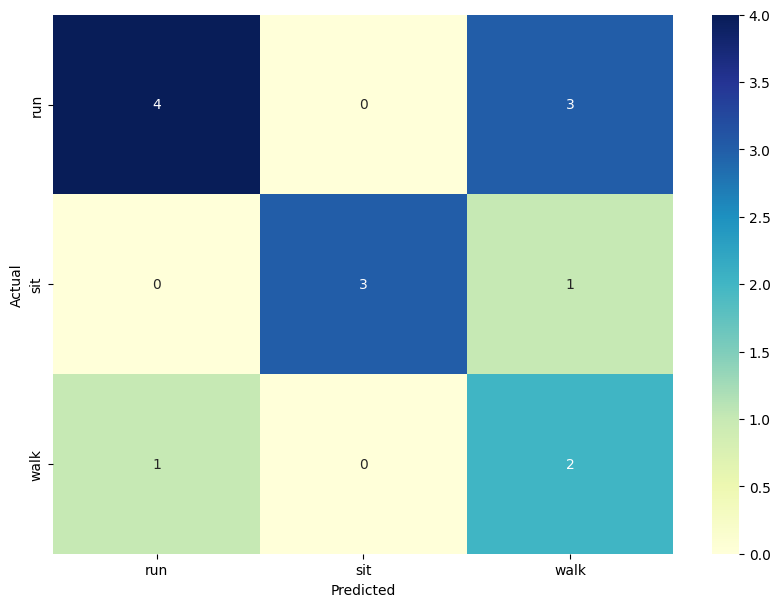

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Average Accuracy: 50.11%
Average Precision: 0.49
Average Recall: 0.50
Average F1-score: 0.49


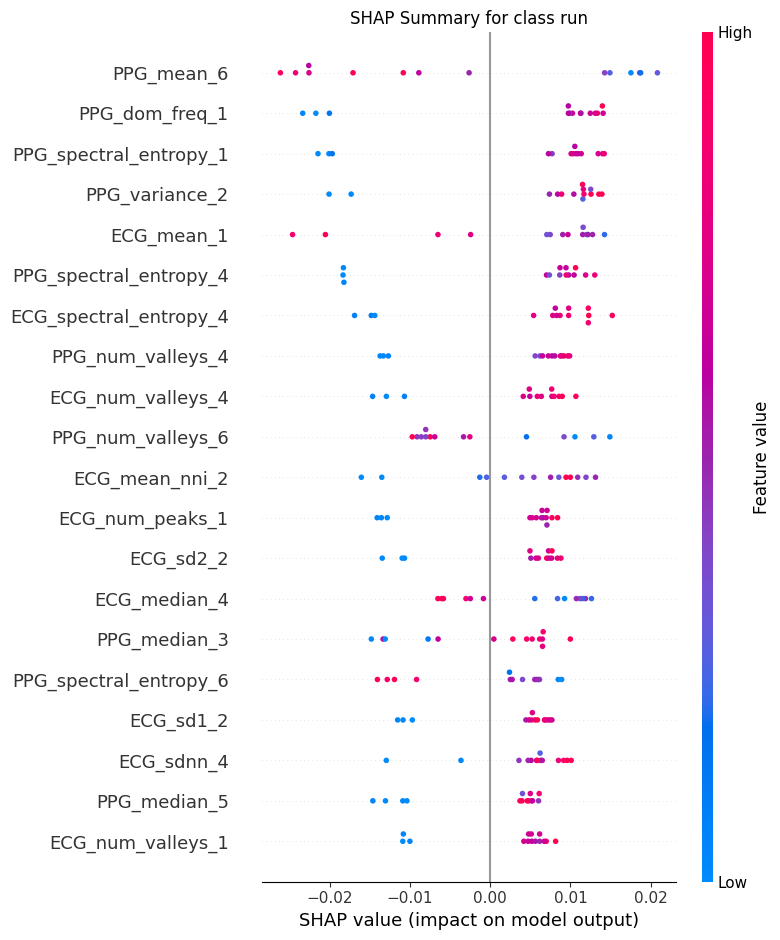

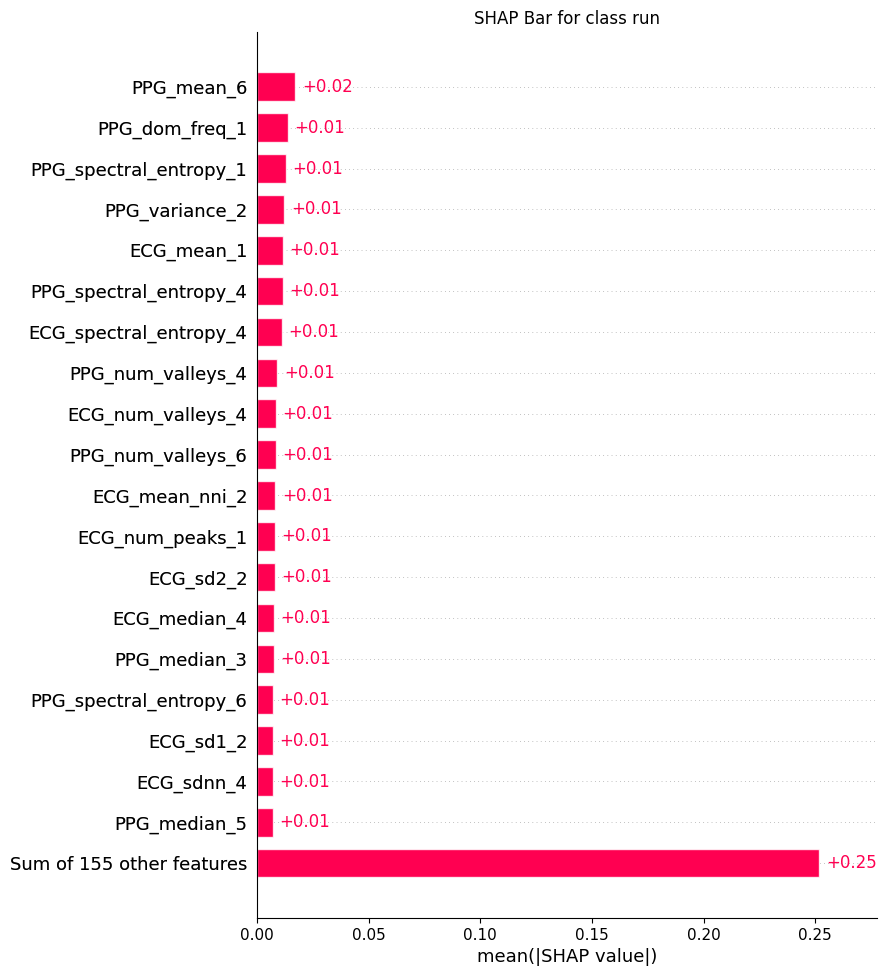

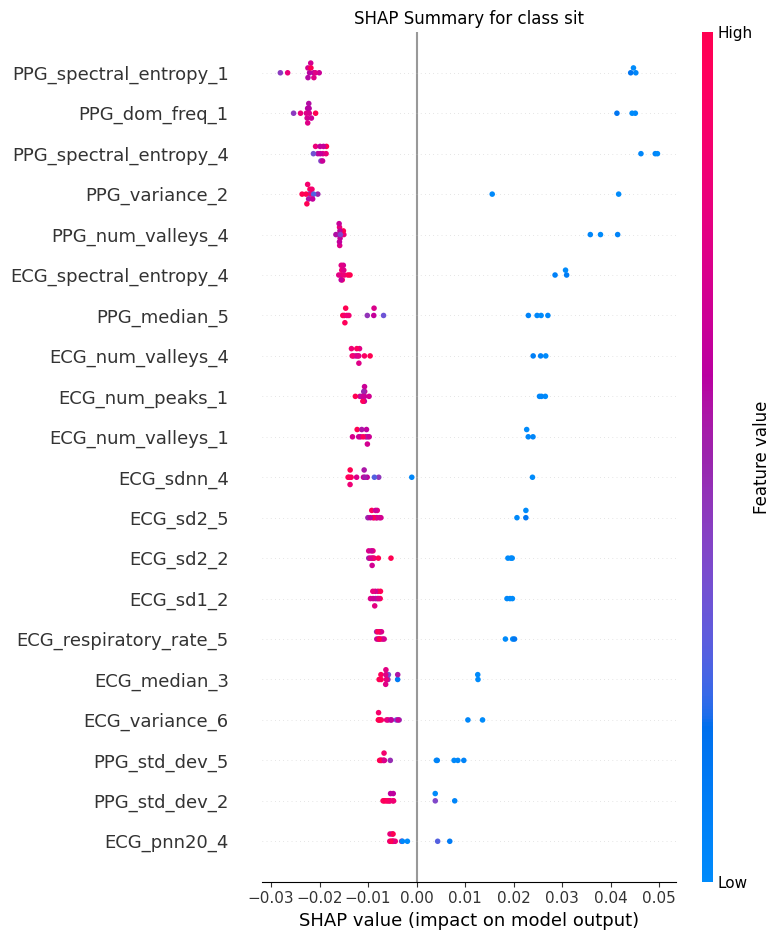

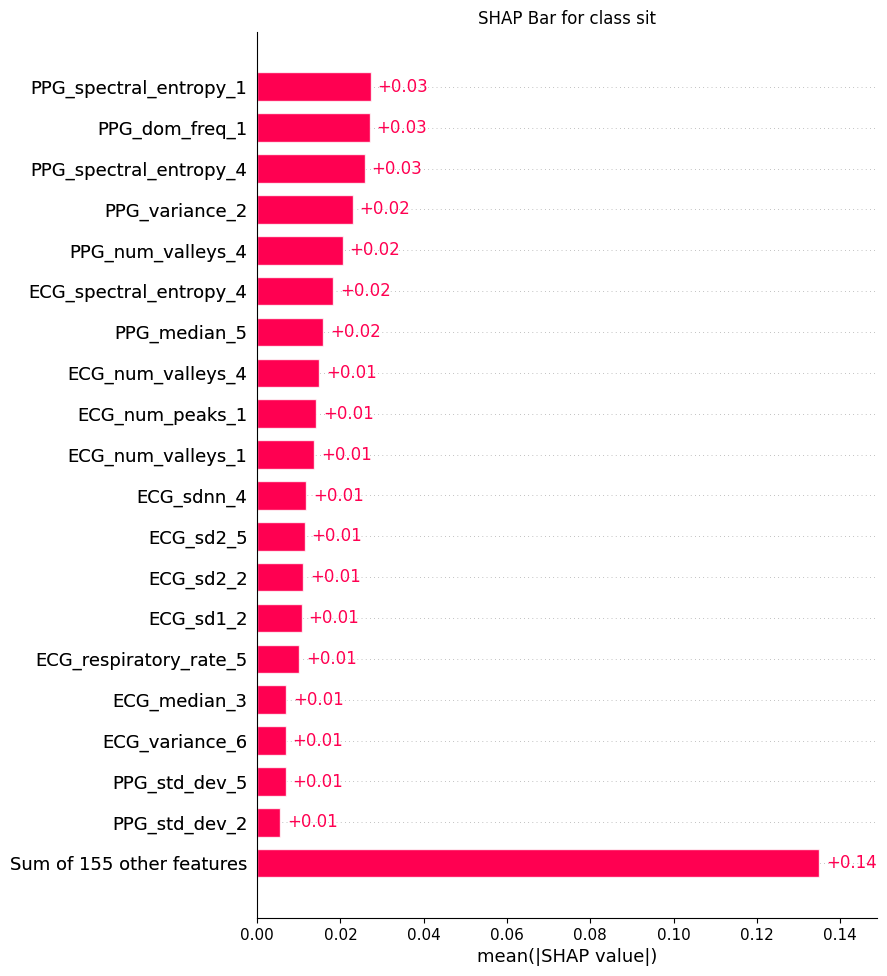

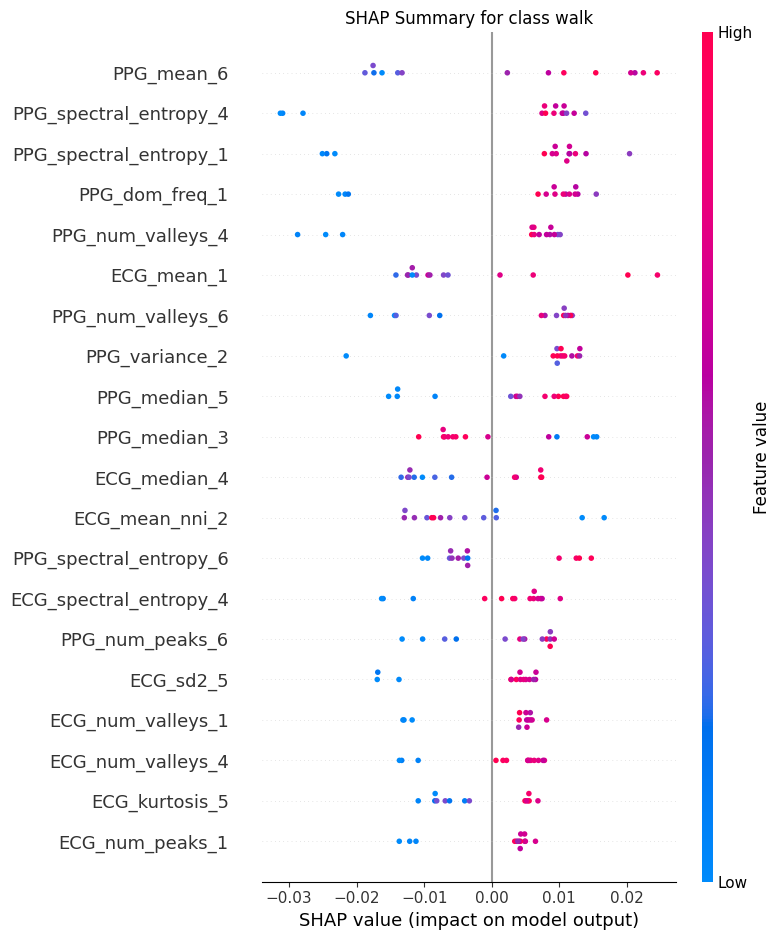

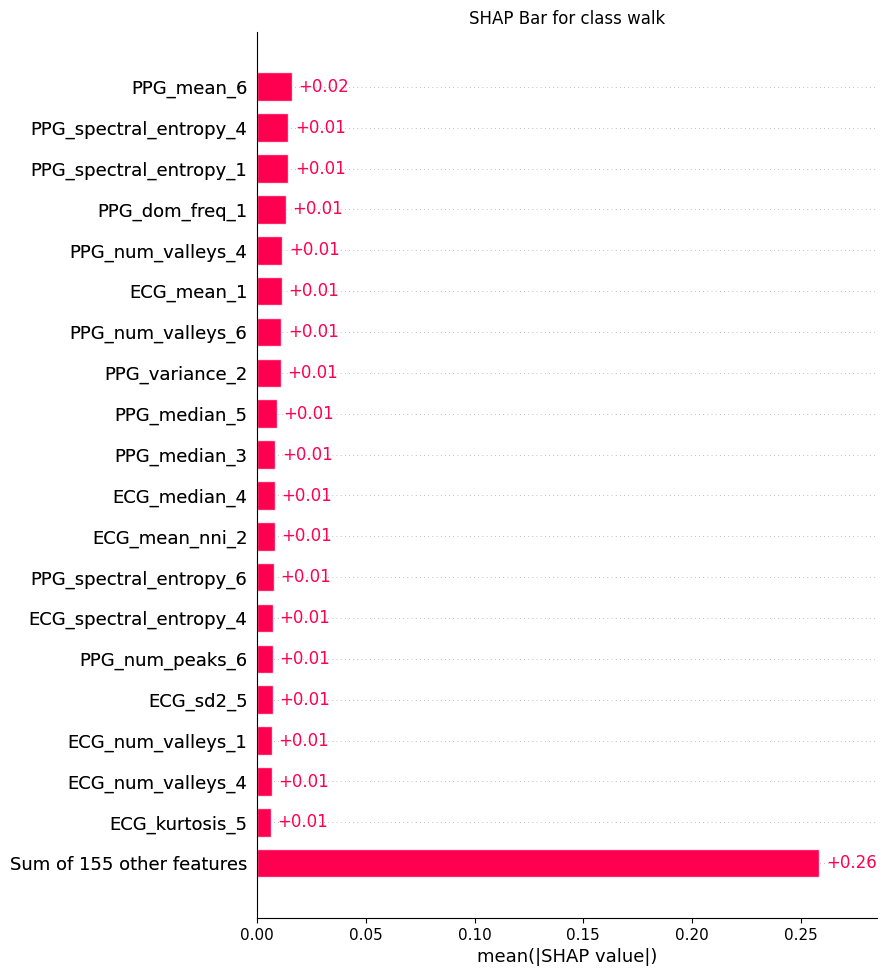

In [10]:
import os
import shap
import wfdb
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Folder containing your datasets
folder_path = '/Users/roupenminassian/physionet.org/files/pulse-transit-time-ppg/1.1.0/Data/'  # Update with your path

features = []
labels = []

# List of keys to extract from both ECG and PPG features
selected_keys_ecg = ['mean', 'median', 'variance', 'std_dev', 'skewness', 'kurtosis', 'num_peaks', 'num_valleys', 'spectral_entropy', 'dom_freq', 'mean_nni','sdnn','sdsd','pnn20','pnn50','rmssd','sd1','sd2','respiratory_rate']
selected_keys_ppg = ['mean', 'median', 'variance', 'std_dev', 'skewness', 'kurtosis', 'num_peaks', 'num_valleys', 'spectral_entropy', 'dom_freq']

# Iterate through all files in the directory
for filename in os.listdir(folder_path):
    if filename.endswith(".dat"):
        # Extract the label from the filename
        label = filename.split('_')[1].split('.')[0]
        labels.append(label)

        # Construct the record name without extensions
        record_name = os.path.join(folder_path, filename.split('.')[0])

        # Load the record using wfdb
        record = wfdb.rdrecord(record_name)

        # Extract ECG and PPG signals
        ecg_index = record.sig_name.index('ecg')
        ecg_signal = record.p_signal[:, ecg_index]
        pleth_2_index = record.sig_name.index('pleth_2')
        pleth_2_signal = record.p_signal[:, pleth_2_index]

        # Prefix the selected keys
        prefixed_keys_ecg = ["ECG_" + key for key in selected_keys_ecg]
        prefixed_keys_ppg = ["PPG_" + key for key in selected_keys_ppg]

        # Extract local features
        ecg_local_features = local_features(ecg_signal, fs, is_ecg=True)
        ppg_local_features = local_features(pleth_2_signal, fs, is_ecg=False)

        # Combine and flatten features using the selected keys
        flattened_features = []
        for idx, (ecg_feat, ppg_feat) in enumerate(zip(ecg_local_features, ppg_local_features)):
            selected_ecg_values = [ecg_feat[key] for key in selected_keys_ecg]
            selected_ppg_values = [ppg_feat[key] for key in selected_keys_ppg]
            flattened_features.extend(selected_ecg_values + selected_ppg_values)

        features.append(flattened_features)

# Convert features and labels into NumPy arrays
X = np.array(features)
y = np.array(labels)

# Initialize lists to store metrics
all_precision = []
all_recall = []
all_f1 = []
all_accuracy = []

# Cross-validation setup
cv = StratifiedKFold(n_splits=5)  # 5-fold cross-validation
clf = RandomForestClassifier(n_estimators=1000, random_state=42)
cross_val_accuracies = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Average Cross-Validation Accuracy: {np.mean(cross_val_accuracies):.2f}")

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Get the class labels
class_labels = clf.classes_

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate additional metrics (Recall, F1, Precision)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.close()

# Calculate and plot Shapley values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Combine the prefixed feature names for SHAP plotting
all_prefixed_features = []

# For ECG features
for idx in range(len(ecg_local_features)):
    suffix = "_" + str(idx + 1)
    for key in prefixed_keys_ecg:
        all_prefixed_features.append(key + suffix)

# For PPG features
for idx in range(len(ppg_local_features)):
    suffix = "_" + str(idx + 1)
    for key in prefixed_keys_ppg:
        all_prefixed_features.append(key + suffix)

# Plot the summary plot to show the most important features
for i, label in enumerate(class_labels):
    plt.figure(figsize=(16, 10))
    plt.title(f"SHAP Summary for class {label}")

    # Display SHAP summary plot
    shap.summary_plot(shap_values[i], X_test, feature_names=all_prefixed_features, show=False)

    # Create Explanation object for bar plot
    expected_value = explainer.expected_value[i]
    explanation = shap.Explanation(values=shap_values[i],
                                   base_values=expected_value,
                                   data=X_test,
                                   feature_names=all_prefixed_features)

    plt.figure(figsize=(16, 10))
    plt.title(f"SHAP Bar for class {label}")

    # Display SHAP bar plot
    shap.plots.bar(explanation, max_display=20, show=False)

# Loop through each fold
for train_index, test_index in cv.split(X_normalized, y):
    X_train, X_test = X_normalized[train_index], X_normalized[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    all_accuracy.append(accuracy)
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)

# Calculate average metrics
avg_accuracy = np.mean(all_accuracy)
avg_precision = np.mean(all_precision)
avg_recall = np.mean(all_recall)
avg_f1 = np.mean(all_f1)

print(f"Average Accuracy: {avg_accuracy * 100:.2f}%")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1-score: {avg_f1:.2f}")

##Binary


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.

A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.


Cross-Validation Accuracies: [0.85714286 0.92307692 0.84615385 1.         0.84615385]
Average Cross-Validation Accuracy: 0.89
Test Accuracy: 92.86%
Classification Report:
              precision    recall  f1-score   support

    movement       0.91      1.00      0.95        10
        rest       1.00      0.75      0.86         4

    accuracy                           0.93        14
   macro avg       0.95      0.88      0.90        14
weighted avg       0.94      0.93      0.93        14



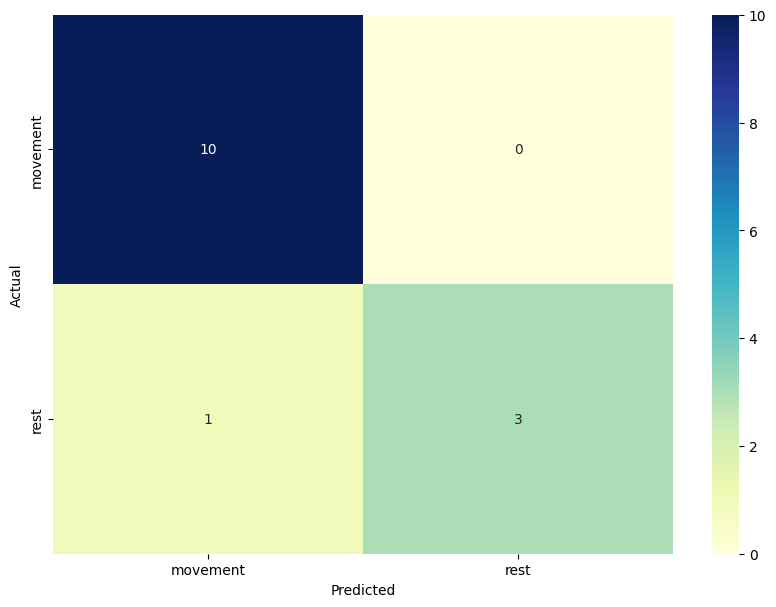

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Average Accuracy: 90.99%
Average Precision: 0.92
Average Recall: 0.91
Average F1-score: 0.91


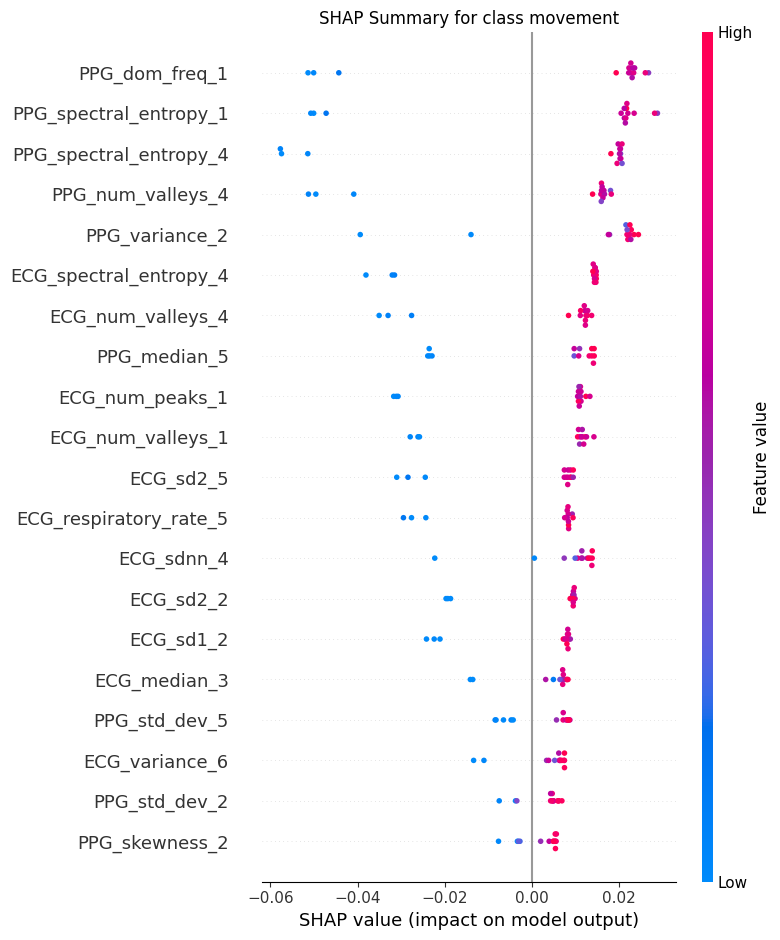

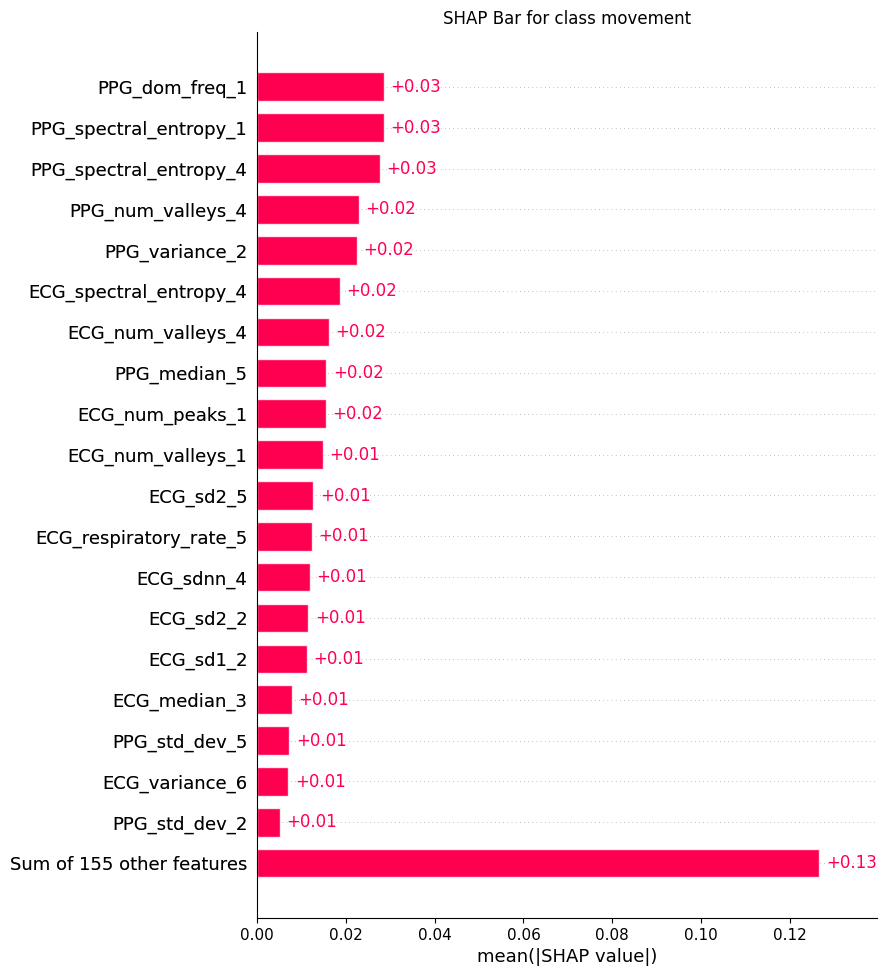

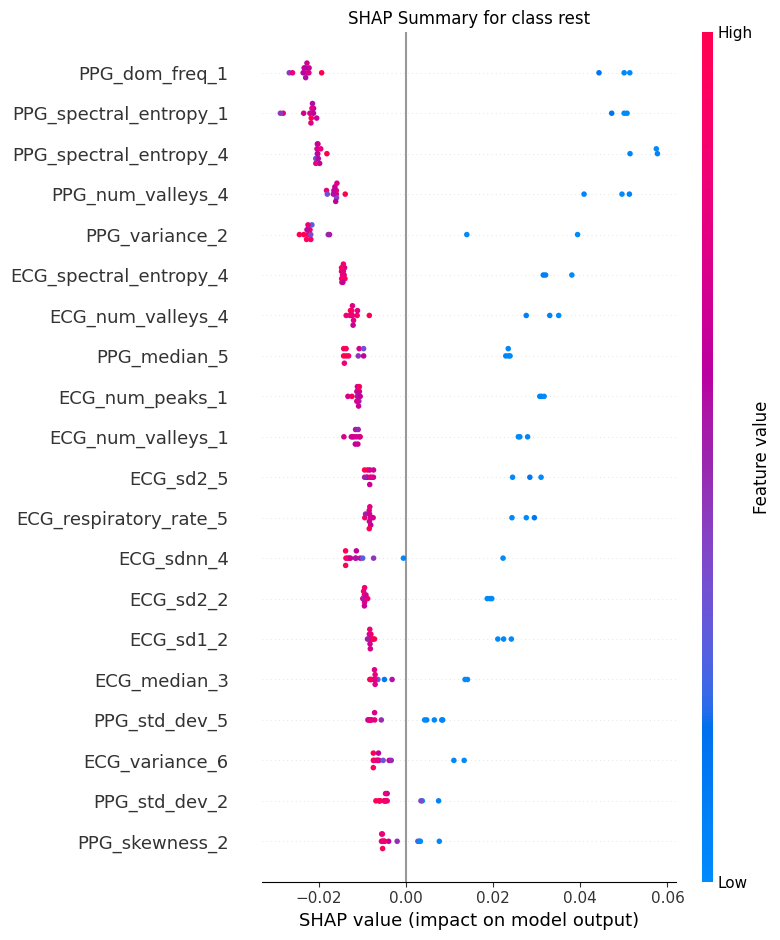

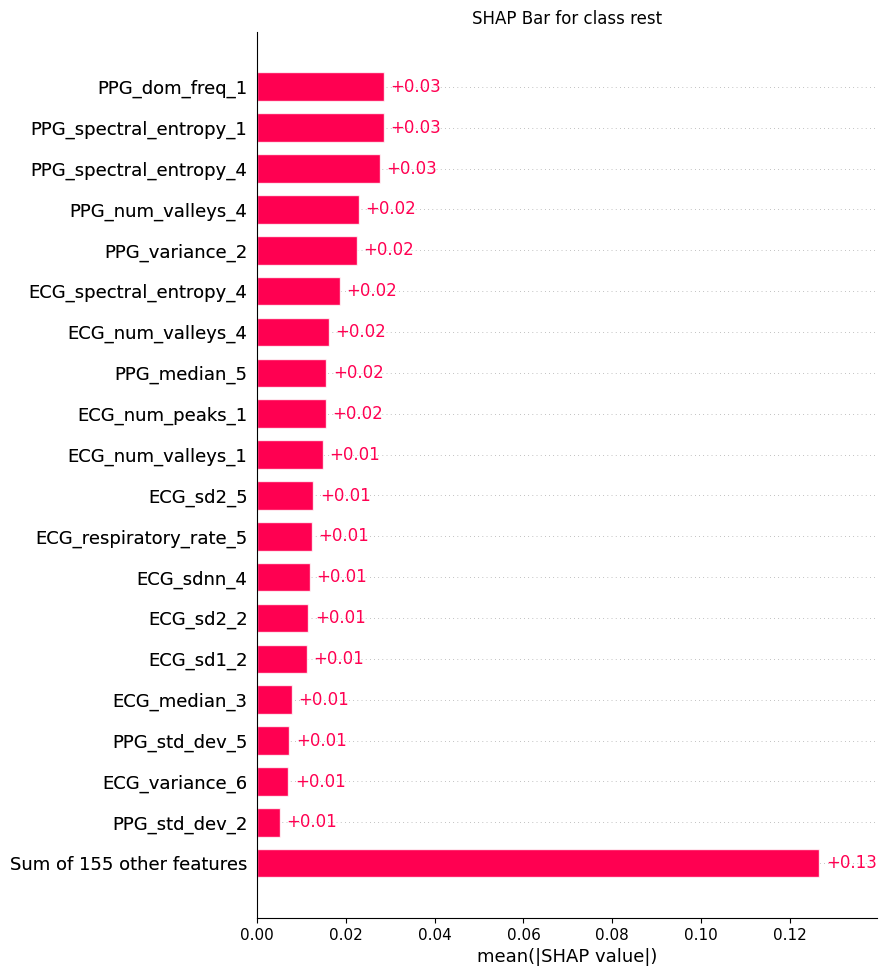

In [12]:
import os
import wfdb
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Folder containing your datasets
folder_path = '/Users/roupenminassian/physionet.org/files/pulse-transit-time-ppg/1.1.0/Data/' # Update with your path

features = []
labels = []

# List of keys to extract from both ECG and PPG features
selected_keys_ecg = ['mean', 'median', 'variance', 'std_dev', 'skewness', 'kurtosis', 'num_peaks', 'num_valleys', 'spectral_entropy', 'dom_freq', 'mean_nni','sdnn','sdsd','pnn20','pnn50','rmssd','sd1','sd2','respiratory_rate']
selected_keys_ppg = ['mean', 'median', 'variance', 'std_dev', 'skewness', 'kurtosis', 'num_peaks', 'num_valleys', 'spectral_entropy', 'dom_freq']

# Iterate through all files in the directory
for filename in os.listdir(folder_path):
    if filename.endswith(".dat"):
        # Extract the label from the filename
        label = filename.split('_')[1].split('.')[0]

        # Convert 'run' and 'walk' labels to 'movement'
        if label in ['run', 'walk']:
            label = 'movement'

        if label == 'sit':
            label = 'rest'

        labels.append(label)

        # Construct the record name without extensions
        record_name = os.path.join(folder_path, filename.split('.')[0])

        # Load the record using wfdb
        record = wfdb.rdrecord(record_name)

        # Extract ECG and PPG signals
        ecg_index = record.sig_name.index('ecg')
        ecg_signal = record.p_signal[:, ecg_index]
        pleth_2_index = record.sig_name.index('pleth_2')
        pleth_2_signal = record.p_signal[:, pleth_2_index]

        # Prefix the selected keys for plotting later
        prefixed_keys_ecg = ["ECG_" + key for key in selected_keys_ecg]
        prefixed_keys_ppg = ["PPG_" + key for key in selected_keys_ppg]

        # Extract local features
        ecg_local_features = local_features(ecg_signal, fs, is_ecg=True)
        ppg_local_features = local_features(pleth_2_signal, fs, is_ecg=False)

        # Combine and flatten features using the selected keys
        flattened_features = []
        for idx, (ecg_feat, ppg_feat) in enumerate(zip(ecg_local_features, ppg_local_features)):
            selected_ecg_values = [ecg_feat[key] for key in selected_keys_ecg]
            selected_ppg_values = [ppg_feat[key] for key in selected_keys_ppg]
            flattened_features.extend(selected_ecg_values + selected_ppg_values)

        features.append(flattened_features)

# Convert features and labels into NumPy arrays
X = np.array(features)
y = np.array(labels)

# Initialize lists to store metrics
all_precision = []
all_recall = []
all_f1 = []
all_accuracy = []

# Cross-validation setup
cv = StratifiedKFold(n_splits=5)  # 5-fold cross-validation
clf = RandomForestClassifier(n_estimators=1000, random_state=42)
cross_val_accuracies = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Average Cross-Validation Accuracy: {np.mean(cross_val_accuracies):.2f}")

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Get the class labels
class_labels = clf.classes_

# Get the feature names (Assuming all_features.keys() has them)
feature_names = list(all_features.keys())

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Calculate additional metrics (Recall, F1, Precision)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.close()

# Calculate and plot Shapley values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Combine the prefixed feature names for SHAP plotting
all_prefixed_features = []

# For ECG features
for idx in range(len(ecg_local_features)):
    suffix = "_" + str(idx + 1)
    for key in prefixed_keys_ecg:
        all_prefixed_features.append(key + suffix)

# For PPG features
for idx in range(len(ppg_local_features)):
    suffix = "_" + str(idx + 1)
    for key in prefixed_keys_ppg:
        all_prefixed_features.append(key + suffix)

# Plot the summary plot to show the most important features
for i, label in enumerate(class_labels):
    plt.figure(figsize=(16, 10))
    plt.title(f"SHAP Summary for class {label}")

    # Display SHAP summary plot
    shap.summary_plot(shap_values[i], X_test, feature_names=all_prefixed_features, show=False)

    # Create Explanation object for bar plot
    expected_value = explainer.expected_value[i]
    explanation = shap.Explanation(values=shap_values[i],
                                   base_values=expected_value,
                                   data=X_test,
                                   feature_names=all_prefixed_features)

    plt.figure(figsize=(16, 10))
    plt.title(f"SHAP Bar for class {label}")

    # Display SHAP bar plot
    shap.plots.bar(explanation, max_display=20, show=False)

# Loop through each fold
for train_index, test_index in cv.split(X_normalized, y):
    X_train, X_test = X_normalized[train_index], X_normalized[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    all_accuracy.append(accuracy)
    all_precision.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)

# Calculate average metrics
avg_accuracy = np.mean(all_accuracy)
avg_precision = np.mean(all_precision)
avg_recall = np.mean(all_recall)
avg_f1 = np.mean(all_f1)

print(f"Average Accuracy: {avg_accuracy * 100:.2f}%")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1-score: {avg_f1:.2f}")